# Image classification CNN

In this lab we will train a convolution neural network for image classification from scratch. 
You will implement a CNN, a training and a validation loop, a custom dataset loader and a couple of helper functions.

## Speed and hardware
Image classification CNN training is typically done on GPUs, often multiple ones, as the process is very computationally intensive. 
This assignment, on the other hand, is created to be run on a CPU: a single training epoch takes 1-5 minutes, depending on the CNN architecture and hardware. 

Specifically, it takes 90 sec for training an epoch on the laptop i7 CPU and 26 sec on the mobile GT940M GPU.
Another option is to use [Google Colab](https://colab.research.google.com/). In the latter case, you will find comments with additional commands to run. Also, all the data (saved networks, datasets) will be auto-deleted after the end of the runtime session, so make sure to download the results of the training.

In [2]:
# FOR COLAB: uncomment and run the following code every time you are starting the session
#!pip install kornia

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import kornia as K
from tqdm import tqdm_notebook as tqdm
from time import time

def imshow_torch(tensor,figsize=(8,6), *kwargs):
    plt.figure(figsize=figsize)
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(K.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return

First, let's download the data. 

**Imagenette** is a subset of 10 easily classified classes from Imagenet (tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute). 

The subset is created by [Jeremy Howard](https://twitter.com/jeremyphoward) and available at https://github.com/fastai/imagenette


In [4]:
# FOR COLAB: uncomment and run the following code every time you are starting the session
# for local: uncomment and run once
#import urllib.request

#url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
#filename = "imagenette2-160.tgz"

#urllib.request.urlretrieve(url, filename)
#!tar -xzf imagenette2-160.tgz

# Dataset and DataLoader 

Now, let's create dataset and data loaders. Dataset is an object, which contains training samples (or can read/generate them on the fly) and all necessary additional information. Data loader is an object, which takes samples from the dataset and generates the batch in efficient way.

For more details, see here 
https://pytorch.org/docs/stable/data.html and here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

There are also several classes for the most common use-cases, in torchvision module:
https://pytorch.org/docs/stable/torchvision/datasets.html


We will use [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class. It assumes that data is already structured like this 'datasetroot/class1/images": 

    root/dog/xxy.jpg
    root/dog/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png

We need to specify two input parameters: path to the root directory and transform. Transform takes PIL.Image and outputs torch.tensor. It can also do some data modification: augmentation, normalization and so on. Let's do it on example. 
We will resize our data to 128x128 px size, transform to tensor and normalize them to have zero mean and unit variance. 
Your first task is to write function `get_dataset_statistics`, which takes a dataset object and return its mean and std (pixel-wise). Remember, that you have to calculate the statistics **only** on training set, not validation or test sets.

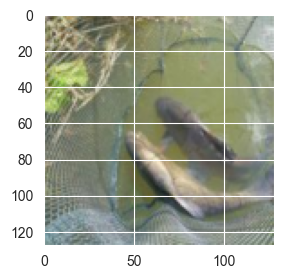

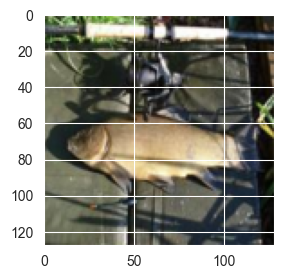

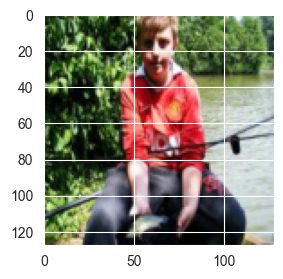

In [5]:
import torchvision.transforms as tfms
train_transform = tfms.Compose([tfms.Resize((128,128)),
                                tfms.ToTensor()])


ImageNette_for_statistics = tv.datasets.ImageFolder('imagenette2-160/train', 
                                    transform = train_transform,)

for i in range(3):
    imshow_torch(ImageNette_for_statistics[i][0], figsize=(3,3))

In [6]:
from cnn_training import get_dataset_statistics
torch.set_default_device('cuda:0')

mean, std = get_dataset_statistics(ImageNette_for_statistics)
# mean, std = [0.46248055, 0.4579692, 0.42981696], [0.27553096, 0.27220666, 0.295335]
print (mean, std)

[0.46247661113739014, 0.45796719193458557, 0.4298022985458374] [0.22823257744312286, 0.22249408066272736, 0.2308284491300583]


In [7]:
for data in ImageNette_for_statistics:
    break
print (data[0].shape)

torch.Size([3, 128, 128])


Now lets create the transform and datasets for training, which include [input normalization](https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn). To avoid overfitting, we may include slight data augmentation into training transform: random cropping and random horizontal flip.


In [8]:
train_transform = tfms.Compose([tfms.Resize((128,128)),
                                #tfms.RandomHorizontalFlip(),
                                tfms.ToTensor(),
                                tfms.Normalize(mean, std)])

val_transform = tfms.Compose([tfms.Resize((128,128)),
                            tfms.ToTensor(),
                            tfms.Normalize(mean, std)])


ImageNette_train = tv.datasets.ImageFolder('imagenette2-160/train',
                                          transform = train_transform)                       

ImageNette_val = tv.datasets.ImageFolder('imagenette2-160/val', 
                                    transform = val_transform)

Now lets create data loaders. The most important parameters are batch size (number of samples in the mini-batch), number of workers (good idea to match them to number of cores of your CPU or less.

In [9]:
# Taken from here https://stackoverflow.com/a/58748125/1983544
import os
num_workers = os.cpu_count() 
if 'sched_getaffinity' in dir(os):
    num_workers = len(os.sched_getaffinity(0)) - 2
print (num_workers)

16


On GPU, the bigger batchsize, the more efficient is training. On the other hand, smaller batch_size may lead to better results in terms of final accuracy. The selection of the proper batch size and other parameters depending on it, is an active research area. We will take the batch of 32. Feel free to adjust it according to your hardware and memory amount.

In [10]:
BS = 32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dl = torch.utils.data.DataLoader(ImageNette_train,
                                      batch_size= 32,
                                       shuffle = True, # important thing to do for training. 
                                       num_workers = num_workers,
                                        generator=torch.Generator(device=device))
val_dl = torch.utils.data.DataLoader(ImageNette_val,
                                      batch_size= 32,
                                     shuffle = False,
                                     num_workers = num_workers,
                                     drop_last=False,
                                     generator=torch.Generator(device=device)) 
#drop_last means "drop last batch from the dataset.
# if it is smaller than required batch size. Might be good thing to do for training, but not for validation.

In [11]:
# from tqdm import tqdm
# from time import time
# t = time()
# for data, labels in tqdm(train_dl):
#     break
# print (data.shape, labels.shape, data.device)

In [12]:
# for data, labels in tqdm(val_dl):
#     break
# print (data.shape, labels.shape, data.device)

```python
for data, labels in train_dl:
    break
print (data.shape, labels.shape)
```

    torch.Size([32, 3, 128, 128]) torch.Size([32])

Now, lets define a model. It should consist of convolution, non-linearity, pooling, batch-norm layers. And finish with a classifier. It is your task to experiment and find a good model. We will show VGG-style model.

Papers to look for inspiration: 
- [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
- [VGGNet](https://arxiv.org/pdf/1409.1556)
- [Systematic Evaluation of Convolution Neural Network Advances on the ImageNet](https://arxiv.org/pdf/1606.02228).
- [ResNet](https://arxiv.org/abs/1512.03385)
- [Bag of tricks](https://arxiv.org/abs/1812.01187)
- [Compounding the Performance Improvements of Assembled Techniques
in a Convolutional Neural Network](https://arxiv.org/pdf/2001.06268.pdf)


But remember that models above are quite beefy, so one may need something lighter for the current task. 

**Important: you need to define your own model, the default one is not enough to pass the assignment**

In [13]:
from cnn_training import SimpleCNN

num_classes = len(ImageNette_train.classes)
model = SimpleCNN(num_classes)

print (model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): Conv2d(128, 256, kernel_size=(3

Now you need to initialize weights of the convolution and linear layers. Good idea would be to use kaiming initialization of scaled orthonormal initialization
https://pytorch.org/docs/stable/nn.init.html

Write a function `weight_init`, which fill the weights with proper random values.

In [14]:
from cnn_training import weight_init

model.features.apply(weight_init)
model.clf.apply(weight_init)


Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=10, bias=True)
)

Now let's write a training loop function `train_and_val_single_epoch`. It should set the model to train mode by model.train(), 
create an optimizer, go through samples in training loader, calculate the loss function and apply the gradients.

https://pytorch.org/docs/stable/optim.html

The simplified version, as shown in pytorch tutorial is as following:

```python3
for input, target in dataset:
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()
validate(model, val_loader, loss_fn)
```

As optimizer is it good idea to take AdamW or SGD. Loss function for classification: CrossEntropyLoss

In [15]:
from cnn_training import train_and_val_single_epoch
help (train_and_val_single_epoch)

Help on function train_and_val_single_epoch in module cnn_training:

train_and_val_single_epoch(model: torch.nn.modules.module.Module, train_loader: torch.utils.data.dataloader.DataLoader, val_loader: torch.utils.data.dataloader.DataLoader, optim: torch.optim.optimizer.Optimizer, loss_fn: torch.nn.modules.module.Module, epoch_idx=0, lr_scheduler=None, writer=None, device: torch.device = device(type='cpu'), additional_params: Dict = {}) -> torch.nn.modules.module.Module
    Function, which runs training over a single epoch in the dataloader and returns the model. Do not forget to set the model into train mode and zero_grad() optimizer before backward.


In the similar fashion implement `validate` function

In [16]:
from cnn_training import validate
help (validate)

Help on function validate in module cnn_training:

validate(model: torch.nn.modules.module.Module, val_loader: torch.utils.data.dataloader.DataLoader, loss_fn: torch.nn.modules.module.Module, device: torch.device = device(type='cpu'), additional_params: Dict = {}) -> Tuple[float, Dict]
    Function, which runs the module over validation set and returns accuracy


Now we are almost ready to run the training. What we are lacking, is a learning_rate value. 
A method, which solves this issue for a broad range of architectures, tasks and optimizers is described in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186) and [A DISCIPLINED APPROACH TO NEURAL NETWORK
HYPER-PARAMETERS: PART 1 – LEARNING RATE, BATCH SIZE, MOMENTUM, AND WEIGHT DECAY](https://arxiv.org/pdf/1803.09820.pdf) by L. Smith.

The algorithm is as following:

1. Save (on HDD or by deepcopy) the original CNN initialization.
2. Create a sequence of learning rates from min_lr to max_lr in log space (use np.logspace)
3. Start training the network, changing the learning rate after 1, 2 or 3 steps of the gradient descent and record the loss value corresponding to each learning rate in the sequence. **Important: steps == mini-batches, not epochs**. `lr_find` should be much faster, than overall training.
4. (optional, for speed-up) Stop when the loss becomes larger than 10x the initial one.
5. (optional) smooth the loss values.
6. Restore model weights from save (1)
7. Plot the loss and select the value, which is either (a) 3x to 10x smaller than the one, corresponding to the minimum of the loss function, or (b) 3x to 10x times smaller than the one just before loss increase. (a) or (b) is your choice.

Implement this proceduce in the `lr_find` function. Use the same optimizer for the `lr_find`, as for the training.

In [17]:
from cnn_training import lr_find, SimpleCNN, weight_init

num_classes = len(ImageNette_train.classes)
model = SimpleCNN(num_classes)
%reload_ext autoreload

model.features.apply(weight_init)
model.clf.apply(weight_init)
loss_fn = nn.CrossEntropyLoss()
losses, lrs = lr_find(model, train_dl, loss_fn, 1e-7, 100, steps=50)

Getting data:   0%|          | 0/2 [00:00<?, ?it/s]

Data loaded: 50.6 seconds


Finding LR:   0%|          | 0/50 [00:01<?, ?it/s]

Loss at lr=1e-07: 2.426295757293701
Loss at lr=1e-07: 2.3438668251037598
Loss at lr=1e-07: 2.3894765377044678
Loss at lr=1.5264179671752333e-07: 2.426295757293701
Loss at lr=1.5264179671752333e-07: 2.3438496589660645
Loss at lr=1.5264179671752333e-07: 2.3893842697143555
Loss at lr=2.329951810515372e-07: 2.426295757293701
Loss at lr=2.329951810515372e-07: 2.3438053131103516
Loss at lr=2.329951810515372e-07: 2.3892688751220703
Loss at lr=3.5564803062231287e-07: 2.426295757293701
Loss at lr=3.5564803062231287e-07: 2.3437583446502686
Loss at lr=3.5564803062231287e-07: 2.389089822769165
Loss at lr=5.428675439323859e-07: 2.426295757293701
Loss at lr=5.428675439323859e-07: 2.3436732292175293
Loss at lr=5.428675439323859e-07: 2.388801097869873
Loss at lr=8.286427728546842e-07: 2.426295757293701
Loss at lr=8.286427728546842e-07: 2.34354305267334
Loss at lr=8.286427728546842e-07: 2.3883748054504395
Loss at lr=1.2648552168552959e-06: 2.426295757293701
Loss at lr=1.2648552168552959e-06: 2.34336352

Now let's plot the learning rates and losses and pick the best value. You can just use plt.semilogx(lrs, losses), but somehow ticks 
are invisible in such a large range, so we will use a solution from stackoverflow.

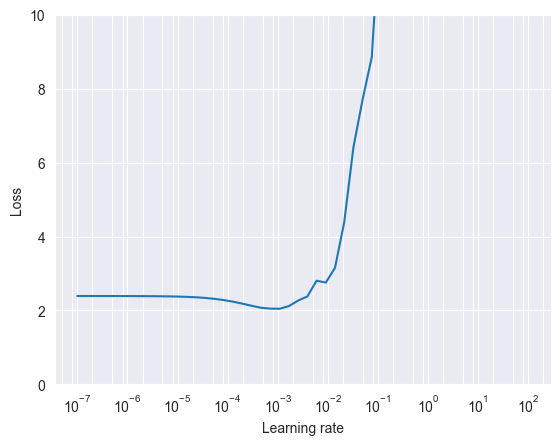

In [18]:
# https://stackoverflow.com/questions/44078409/matplotlib-semi-log-plot-minor-tick-marks-are-gone-when-range-is-large/44079725#44079725
def plot_lrs_losses(lrs, losses):
    import matplotlib.ticker
    fig, ax=plt.subplots()
    ax.semilogx(lrs, losses)
    ax.set_ylim([0, 10.])
    ax.grid(True, which="both")
    locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
    ax.xaxis.set_major_locator(locmaj)
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.5, 0.8),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    plt.show()
    return
plot_lrs_losses(lrs, losses)

Here is the plot for AdamW optimizer with exampleCNN 
```python
plot_lrs_losses(lrs, losses)
```
![image.png](training-imagenette-CNN_files/att_00003.png)

And for SGD

![image.png](training-imagenette-CNN_files/att_00000.png)

A good value here would be 1e-3 for AdamW and 3e-3 for SGD with momentum.

We will use [tensorboard](https://www.tensorflow.org/tensorboard) for plotting training and validation statistics. 
It works as follows: the `writer` object writes logs in a specific format as training goes on. 
In a separate console window, run 
```bash
tensorboard --logdir=runs --port=6006
```

And open [localhost:6006](http://localhost:6006/) in a separate browser window.

To add a value to tensorboard, one needs to use function add_scalar.
For detailed reference see https://pytorch.org/docs/stable/tensorboard.html


```python
writer.add_scalar("Loss/val", loss.item(), epoch_idx)
```

If you are running on Google Colab, you can open tensorboard in the cell:


```python
%load_ext tensorboard
%tensorboard --logdir runs
```

In [19]:
from torch.utils.tensorboard import SummaryWriter

In [20]:
torch.ones(9).device

device(type='cuda', index=0)

In [21]:
# FOR COLAB: uncomment and run the following code every time you are starting the session.
# You can monitor the training here
#%load_ext tensorboard
#%tensorboard --logdir runs

In [22]:
from cnn_training import train_and_val_single_epoch, SimpleCNN
from torch.utils.tensorboard import SummaryWriter

model = SimpleCNN(10)


model.features.apply(weight_init)
model.clf.apply(weight_init)
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(comment="AdamW_no_scheduler") #Comment is a name for graph (see screenshot below)

Split to continue training if desired

In [23]:
opt = torch.optim.AdamW(model.parameters(),lr=1e-3, weight_decay=1e-4, eps=1e-2)
#opt = torch.optim.SGD(model.parameters(),lr=3e-3, weight_decay=1e-4, momentum=0.9)
for ep in range(10):
    t=time()
    model = train_and_val_single_epoch(model, train_dl, val_dl, opt, loss_fn, ep, 
                                       writer=writer,
                                       device = device, additional_params={"with_acc": True})
    el = time() - t
    print (f"Train epoch in {el:.1f} sec")

Starting validation


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  2.2880232334136963
Loss:  2.3084259033203125
Loss:  2.221881628036499
Loss:  2.339033365249634
Loss:  2.182861804962158
Loss:  2.1769351959228516
Loss:  2.2689549922943115
Loss:  2.256782054901123
Loss:  2.1762242317199707
Loss:  2.044186592102051
Loss:  2.115856647491455
Loss:  1.9872233867645264
Loss:  2.2427592277526855
Loss:  2.008197069168091
Loss:  2.182981491088867
Loss:  1.9392112493515015
Loss:  2.0112476348876953
Loss:  2.0627341270446777
Loss:  1.9987318515777588
Loss:  1.8401086330413818
Loss:  2.2210967540740967
Loss:  1.8238710165023804
Loss:  2.081092357635498
Loss:  2.006826877593994
Loss:  2.057690382003784
Loss:  1.8724164962768555
Loss:  2.121387004852295
Loss:  1.9579951763153076
Loss:  2.032123565673828
Loss:  1.9080240726470947
Loss:  1.9282763004302979
Loss:  1.8427972793579102
Loss:  2.148831844329834
Loss:  1.9651333093643188
Loss:  1.88838791847229
Loss:  2.1088919639587402
Loss:  1.8646494150161743
Loss:  1.9643301963806152
Loss:  2.0228524208068848
Lo

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  1.210790991783142
Loss:  1.3663573265075684
Loss:  1.5004241466522217
Loss:  1.3173632621765137
Loss:  1.5744847059249878
Loss:  1.5449697971343994
Loss:  1.3844738006591797
Loss:  1.2193621397018433
Loss:  1.362165093421936
Loss:  1.6107197999954224
Loss:  1.4714370965957642
Loss:  1.4586650133132935
Loss:  1.4640003442764282
Loss:  1.0654733180999756
Loss:  1.4335660934448242
Loss:  1.6269116401672363
Loss:  1.20277738571167
Loss:  1.95428466796875
Loss:  1.4989044666290283
Loss:  1.5043270587921143
Loss:  1.7489181756973267
Loss:  1.9216188192367554
Loss:  1.4876031875610352
Loss:  1.518974781036377
Loss:  1.522191047668457
Loss:  1.6995279788970947
Loss:  1.780206561088562
Loss:  1.567922830581665
Loss:  1.1841180324554443
Loss:  1.5254793167114258
Loss:  1.6462831497192383
Loss:  1.1883318424224854
Loss:  1.7282872200012207
Loss:  1.5205938816070557
Loss:  1.5153017044067383
Loss:  1.4484559297561646
Loss:  1.533182144165039
Loss:  1.2007917165756226
Loss:  1.97466337680816

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  0.9817702770233154
Loss:  1.2645542621612549
Loss:  1.334333896636963
Loss:  1.5009554624557495
Loss:  1.2624001502990723
Loss:  1.227856993675232
Loss:  1.1670215129852295
Loss:  1.152143955230713
Loss:  1.0145092010498047
Loss:  1.1865508556365967
Loss:  1.1985493898391724
Loss:  1.1965405941009521
Loss:  1.049602746963501
Loss:  1.2405723333358765
Loss:  1.2318930625915527
Loss:  1.114571452140808
Loss:  1.12199068069458
Loss:  1.1964613199234009
Loss:  1.2584182024002075
Loss:  1.0979101657867432
Loss:  1.137907862663269
Loss:  1.2707940340042114
Loss:  1.1230552196502686
Loss:  1.3312079906463623
Loss:  0.9357591271400452
Loss:  1.2924634218215942
Loss:  1.370276689529419
Loss:  1.383105993270874
Loss:  1.3057372570037842
Loss:  1.0565528869628906
Loss:  1.3783910274505615
Loss:  1.151079535484314
Loss:  0.9752954840660095
Loss:  1.2450065612792969
Loss:  1.2330906391143799
Loss:  1.3415069580078125
Loss:  1.4672315120697021
Loss:  0.9684682488441467
Loss:  1.27915871143341

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  1.3185536861419678
Loss:  0.7055099606513977
Loss:  1.0182056427001953
Loss:  0.9346286058425903
Loss:  0.9249078631401062
Loss:  0.7241885662078857
Loss:  1.0507173538208008
Loss:  0.4829275608062744
Loss:  0.8899595737457275
Loss:  0.7200521230697632
Loss:  1.1610760688781738
Loss:  1.363660454750061
Loss:  0.879594624042511
Loss:  1.2561404705047607
Loss:  1.3217833042144775
Loss:  1.6109296083450317
Loss:  1.0277425050735474
Loss:  0.9615315198898315
Loss:  0.7859069108963013
Loss:  1.0415303707122803
Loss:  1.152443766593933
Loss:  0.8186584711074829
Loss:  0.9063968062400818
Loss:  1.1670023202896118
Loss:  1.2004083395004272
Loss:  0.8886703848838806
Loss:  0.9533634185791016
Loss:  0.7885880470275879
Loss:  0.835052490234375
Loss:  0.9214301705360413
Loss:  1.2874683141708374
Loss:  1.1179450750350952
Loss:  0.7757909297943115
Loss:  0.6516103744506836
Loss:  1.0123848915100098
Loss:  1.185130000114441
Loss:  0.7770357728004456
Loss:  0.7440107464790344
Loss:  0.92482030

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  0.8061255812644958
Loss:  1.1935522556304932
Loss:  0.956701934337616
Loss:  0.6645053625106812
Loss:  1.058815836906433
Loss:  0.8620219230651855
Loss:  0.8329148292541504
Loss:  0.864477276802063
Loss:  1.08103346824646
Loss:  0.7603041529655457
Loss:  0.9780856966972351
Loss:  1.069749355316162
Loss:  0.7697023153305054
Loss:  0.8669884204864502
Loss:  0.8170247077941895
Loss:  1.3114361763000488
Loss:  0.8277262449264526
Loss:  0.7216770648956299
Loss:  0.6550487875938416
Loss:  0.945622980594635
Loss:  0.7671492695808411
Loss:  0.991418719291687
Loss:  1.0390191078186035
Loss:  0.9828715920448303
Loss:  0.9248722195625305
Loss:  0.6842276453971863
Loss:  0.6714022159576416
Loss:  1.0516339540481567
Loss:  0.8398833870887756
Loss:  0.7343447208404541
Loss:  0.9589932560920715
Loss:  0.6902940273284912
Loss:  0.67706298828125
Loss:  0.6499173045158386
Loss:  0.6412633657455444
Loss:  0.5814211368560791
Loss:  0.9979336857795715
Loss:  1.3086237907409668
Loss:  0.4213005304336

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  0.9556065201759338
Loss:  0.8110387921333313
Loss:  0.5999400615692139
Loss:  0.8947299122810364
Loss:  0.5897514224052429
Loss:  0.620711088180542
Loss:  0.9636917114257812
Loss:  1.2035964727401733
Loss:  0.8753449320793152
Loss:  1.094577670097351
Loss:  0.9715410470962524
Loss:  0.956822395324707
Loss:  0.7259913682937622
Loss:  1.1347577571868896
Loss:  1.0746477842330933
Loss:  0.7072251439094543
Loss:  0.6054167747497559
Loss:  0.6869636178016663
Loss:  0.6873475313186646
Loss:  0.7694317102432251
Loss:  0.5456793904304504
Loss:  0.5568162798881531
Loss:  0.8212888836860657
Loss:  0.5522732138633728
Loss:  0.7687060832977295
Loss:  0.9467213153839111
Loss:  0.6220423579216003
Loss:  0.8102917075157166
Loss:  0.7309467196464539
Loss:  0.5814445614814758
Loss:  0.7553847432136536
Loss:  0.6930935978889465
Loss:  0.7870259284973145
Loss:  0.7362552881240845
Loss:  1.2108166217803955
Loss:  0.7195072770118713
Loss:  0.5856996178627014
Loss:  0.9097999930381775
Loss:  0.836251

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  0.5251797437667847
Loss:  0.8671938180923462
Loss:  0.7011793255805969
Loss:  0.8990536332130432
Loss:  0.5015231966972351
Loss:  0.6637660264968872
Loss:  0.8881023526191711
Loss:  0.7311519384384155
Loss:  0.5919067859649658
Loss:  0.8984140157699585
Loss:  0.9010393023490906
Loss:  0.6265351176261902
Loss:  0.5522664189338684
Loss:  0.8413518071174622
Loss:  0.7084692120552063
Loss:  0.8639265298843384
Loss:  0.5324679017066956
Loss:  0.9610911011695862
Loss:  0.47189298272132874
Loss:  0.6230178475379944
Loss:  0.7199350595474243
Loss:  0.687541127204895
Loss:  0.7651025056838989
Loss:  0.5184324383735657
Loss:  0.7453795075416565
Loss:  0.6928067803382874
Loss:  0.6842588782310486
Loss:  0.6749051809310913
Loss:  0.6123249530792236
Loss:  0.8181267976760864
Loss:  0.6592696905136108
Loss:  0.7017114758491516
Loss:  0.6830443739891052
Loss:  0.9432756304740906
Loss:  0.712411642074585
Loss:  0.7933660745620728
Loss:  0.8576666712760925
Loss:  0.7777186036109924
Loss:  0.7494

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  0.675186812877655
Loss:  0.7524130344390869
Loss:  0.4033656418323517
Loss:  0.3669171631336212
Loss:  0.7465402483940125
Loss:  0.28856998682022095
Loss:  0.7158038020133972
Loss:  0.5312550067901611
Loss:  0.39384961128234863
Loss:  0.39604702591896057
Loss:  0.4348348379135132
Loss:  0.7276106476783752
Loss:  0.8084039092063904
Loss:  0.6251450777053833
Loss:  0.46762919425964355
Loss:  0.7034518718719482
Loss:  0.4874855875968933
Loss:  0.5172938704490662
Loss:  0.8926873207092285
Loss:  0.8149902820587158
Loss:  0.3434910774230957
Loss:  0.6508600115776062
Loss:  0.8161491751670837
Loss:  0.5570610165596008
Loss:  0.6418229341506958
Loss:  0.6427494883537292
Loss:  0.6159266829490662
Loss:  0.6530107855796814
Loss:  0.4697321951389313
Loss:  0.4237852692604065
Loss:  0.5684966444969177
Loss:  0.46403592824935913
Loss:  0.6285327672958374
Loss:  0.6853485703468323
Loss:  0.5645844340324402
Loss:  0.5838425159454346
Loss:  0.46821075677871704
Loss:  0.6723833680152893
Loss:  

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  0.49861595034599304
Loss:  0.6068594455718994
Loss:  0.4076915383338928
Loss:  0.34136179089546204
Loss:  0.6046667695045471
Loss:  0.7414684295654297
Loss:  0.32142287492752075
Loss:  0.6942988634109497
Loss:  0.7369670271873474
Loss:  0.5279966592788696
Loss:  0.4478941559791565
Loss:  1.0609066486358643
Loss:  0.3291056454181671
Loss:  0.5520256161689758
Loss:  0.5126801133155823
Loss:  0.42791321873664856
Loss:  0.5263432264328003
Loss:  0.48375943303108215
Loss:  0.362322598695755
Loss:  0.5687523484230042
Loss:  0.5394048094749451
Loss:  0.5443198084831238
Loss:  0.7510664463043213
Loss:  0.4364655017852783
Loss:  0.3217466175556183
Loss:  0.41121137142181396
Loss:  1.104074478149414
Loss:  0.47364991903305054
Loss:  0.5447458028793335
Loss:  0.6020345091819763
Loss:  0.3166621923446655
Loss:  0.5462204217910767
Loss:  0.5251404047012329
Loss:  0.6118239760398865
Loss:  0.6115670204162598
Loss:  0.5936130285263062
Loss:  0.3957313895225525
Loss:  0.7350974678993225
Loss:  

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  0.835665225982666
Loss:  0.6119992733001709
Loss:  0.6534844636917114
Loss:  0.4987720847129822
Loss:  0.18334941565990448
Loss:  0.764701783657074
Loss:  0.5178207755088806
Loss:  0.7990686297416687
Loss:  0.45147427916526794
Loss:  0.2867166996002197
Loss:  0.6774643659591675
Loss:  0.7044841647148132
Loss:  0.45219600200653076
Loss:  0.7399097084999084
Loss:  0.8526403307914734
Loss:  0.4573137164115906
Loss:  0.49563419818878174
Loss:  0.4608209431171417
Loss:  0.6521027088165283
Loss:  0.6693905591964722
Loss:  0.3236772418022156
Loss:  0.25954827666282654
Loss:  0.7778587937355042
Loss:  0.6091623902320862
Loss:  0.3732357621192932
Loss:  0.6058421730995178
Loss:  0.7132260203361511
Loss:  0.43328121304512024
Loss:  0.5128645896911621
Loss:  0.3311588168144226
Loss:  0.21069344878196716
Loss:  0.29919126629829407
Loss:  0.6853316426277161
Loss:  0.46289119124412537
Loss:  0.6694908142089844
Loss:  0.4410014748573303
Loss:  0.47713372111320496
Loss:  0.47221267223358154
Los

Screenshot from tensorboard for the SGD
![image.png](training-imagenette-CNN_files/att_00001.png)

Screenshot from tensorboard for the AdamW
![image.png](training-imagenette-CNN_files/att_00004.png)

A good idea would be to use a learning rate scheduler i.e. not keeping the learning rate constant, but changing it  on the fly. See the different learning rate schedules example (from [Systematic Evaluation of Convolution Neural Network Advances on the ImageNet](https://arxiv.org/pdf/1606.02228) paper).

![image.png](training-imagenette-CNN_files/att_00002.png)

Lets compare no-schedule (above) with one-cycle.
Good schedules to try will be one-cycle policy, step-policy, linear policy.
See an example here:
https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
from cnn_training import *
loss_fn = nn.CrossEntropyLoss()
#Re-init the model
model = SimpleCNN(10)
model.features.apply(weight_init)
model.clf.apply(weight_init)
epochs = 10
writer = SummaryWriter(comment="AdamW_OneCycleSched") 
opt1 = torch.optim.AdamW(model.parameters(),lr=1e-3, weight_decay=1e-4, eps=1e-2)
lr_sched = OneCycleLR(opt1, max_lr=3e-3, steps_per_epoch=len(train_dl), epochs=epochs)

for ep in range(epochs):
    t=time()
    model = train_and_val_single_epoch(model, train_dl, val_dl, opt1, loss_fn, ep, lr_sched, writer=writer,
                                      device = torch.device('cuda'), additional_params={"with_acc": True})
    el = time() -t
    print (f"Train epoch in {el:.1f} sec")
    torch.save(model, f'models/at_{ep}')

Starting validation


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  2.301600933074951
Loss:  2.332935094833374
Loss:  2.3160533905029297
Loss:  2.3656911849975586
Loss:  2.3006811141967773
Loss:  2.3257012367248535
Loss:  2.313230276107788
Loss:  2.2818551063537598
Loss:  2.2722318172454834
Loss:  2.2803308963775635
Loss:  2.247211456298828
Loss:  2.2329261302948
Loss:  2.2598209381103516
Loss:  2.249577283859253
Loss:  2.285346508026123
Loss:  2.263368844985962
Loss:  2.2867400646209717
Loss:  2.224034070968628
Loss:  2.2520506381988525
Loss:  2.2216548919677734
Loss:  2.261687994003296
Loss:  2.2951529026031494
Loss:  2.205375909805298
Loss:  2.2240734100341797
Loss:  2.2083168029785156
Loss:  2.1515467166900635
Loss:  2.183898687362671
Loss:  2.226043701171875
Loss:  2.201260566711426
Loss:  2.2043848037719727
Loss:  2.2136385440826416
Loss:  2.2019801139831543
Loss:  2.2424893379211426
Loss:  2.1667263507843018
Loss:  2.17323637008667
Loss:  2.2296717166900635
Loss:  2.111905574798584
Loss:  2.1728570461273193
Loss:  2.178410053253174
Loss: 

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  1.9428653717041016
Loss:  1.616260051727295
Loss:  1.7292836904525757
Loss:  1.4555995464324951
Loss:  1.5076731443405151
Loss:  2.086724042892456
Loss:  1.8207443952560425
Loss:  1.7155512571334839
Loss:  1.6362833976745605
Loss:  1.5582958459854126
Loss:  1.9261811971664429
Loss:  2.020904541015625
Loss:  1.5924937725067139
Loss:  2.1646859645843506
Loss:  1.6057286262512207
Loss:  1.9387693405151367
Loss:  1.5723949670791626
Loss:  1.4698607921600342
Loss:  1.5527052879333496
Loss:  1.7960973978042603
Loss:  1.683243751525879
Loss:  1.405290126800537
Loss:  1.7132648229599
Loss:  1.832897663116455
Loss:  1.7909501791000366
Loss:  1.4293347597122192
Loss:  1.4520498514175415
Loss:  1.6007602214813232
Loss:  1.6915937662124634
Loss:  1.6862843036651611
Loss:  1.6893541812896729
Loss:  1.6439783573150635
Loss:  1.8126622438430786
Loss:  1.668401837348938
Loss:  1.2759708166122437
Loss:  1.7962852716445923
Loss:  1.3341114521026611
Loss:  1.7303800582885742
Loss:  1.7866312265396

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  2.1440060138702393
Loss:  1.2151349782943726
Loss:  1.7035263776779175
Loss:  1.1095279455184937
Loss:  1.195237159729004
Loss:  1.198662519454956
Loss:  1.3153867721557617
Loss:  1.3768064975738525
Loss:  1.6495987176895142
Loss:  1.1720741987228394
Loss:  0.945583701133728
Loss:  1.2979427576065063
Loss:  1.5722302198410034
Loss:  1.4904600381851196
Loss:  1.278756856918335
Loss:  1.3066233396530151
Loss:  1.3273513317108154
Loss:  1.0659562349319458
Loss:  1.2999383211135864
Loss:  1.6936078071594238
Loss:  1.233325481414795
Loss:  1.5359790325164795
Loss:  1.1875641345977783
Loss:  1.14665949344635
Loss:  1.5247974395751953
Loss:  1.1781611442565918
Loss:  1.4070378541946411
Loss:  1.279302716255188
Loss:  1.4651676416397095
Loss:  1.036423683166504
Loss:  1.6241579055786133
Loss:  1.5831581354141235
Loss:  1.5230209827423096
Loss:  1.748646855354309
Loss:  1.6885085105895996
Loss:  1.519420862197876
Loss:  1.7332226037979126
Loss:  1.6837183237075806
Loss:  1.20665562152862

  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  1.4751451015472412
Loss:  1.2254736423492432
Loss:  1.3483929634094238
Loss:  1.6437104940414429
Loss:  0.878378689289093
Loss:  1.270268440246582
Loss:  1.1315784454345703
Loss:  1.3151848316192627
Loss:  1.2519315481185913
Loss:  1.1116487979888916
Loss:  1.0794432163238525
Loss:  0.9470773935317993
Loss:  1.1278847455978394
Loss:  0.8576710820198059
Loss:  1.1556403636932373
Loss:  1.2945642471313477
Loss:  1.006390929222107
Loss:  1.3451875448226929
Loss:  1.376217246055603
Loss:  1.095022439956665
Loss:  1.1590924263000488
Loss:  1.06273353099823
Loss:  0.949017345905304
Loss:  1.201043963432312
Loss:  1.1760120391845703
Loss:  0.9787690043449402
Loss:  1.227110743522644
Loss:  1.1466174125671387
Loss:  0.9502726793289185
Loss:  1.1207563877105713
Loss:  0.949430525302887
Loss:  0.8978533744812012
Loss:  0.9875632524490356
Loss:  1.25874924659729
Loss:  1.3082542419433594
Loss:  1.1577434539794922
Loss:  0.9498104453086853
Loss:  1.552892804145813
Loss:  1.4239531755447388


  0%|          | 0/296 [00:00<?, ?it/s]

Loss:  0.9292007088661194
Loss:  0.9743926525115967
Loss:  0.8401959538459778
Loss:  0.8700253367424011
Loss:  0.7671597599983215
Loss:  0.92890465259552
Loss:  0.9076613783836365
Loss:  1.1006194353103638
Loss:  1.2109564542770386
Loss:  1.2775155305862427
Loss:  0.7554928064346313
Loss:  0.7349585294723511
Loss:  0.8188376426696777
Loss:  0.43746960163116455
Loss:  0.9306925535202026
Loss:  0.8954044580459595
Loss:  0.7371840476989746
Loss:  0.8894256353378296
Loss:  0.8000120520591736
Loss:  1.0571067333221436
Loss:  1.1484850645065308
Loss:  0.9356515407562256
Loss:  1.0745973587036133
Loss:  0.9498302936553955
Loss:  1.0865626335144043
Loss:  0.952458381652832
Loss:  0.8228199481964111
Loss:  0.9616096615791321
Loss:  0.7438578605651855
Loss:  0.8805215954780579
Loss:  0.9191257357597351
Loss:  0.9574339985847473
Loss:  1.0306017398834229
Loss:  0.7564725875854492
Loss:  0.7295501232147217
Loss:  1.1167716979980469
Loss:  0.6499552726745605
Loss:  0.8773111701011658
Loss:  1.04619

# Reference example

```python
from torch.optim.lr_scheduler import OneCycleLR
from cnn_training import *
loss_fn = nn.CrossEntropyLoss()
#Re-init the model
model = SimpleCNN(10)
model.features.apply(weight_init)
model.clf.apply(weight_init)

writer = SummaryWriter(comment="AdamW_OneCycleSched") 
opt1 = torch.optim.AdamW(model.parameters(),lr=1e-3, weight_decay=1e-4, eps=1e-2)
lr_sched = OneCycleLR(opt1, max_lr=3e-3, steps_per_epoch=len(train_dl), epochs=3)

for ep in range(3):
    t=time()
    model = train_and_val_single_epoch(model, train_dl, val_dl, opt1, loss_fn, ep, lr_sched, writer=writer)
    el = time() -t
    print (f"Train epoch in {el:.1f} sec")
```

![image.png](training-imagenette-CNN_files/att_00005.png)

Training for more epochs than 3 would lead to better results. 

## Testing the network

Now we need to define a custom dataset to classify the folder with images. The `ImageFolder` is not suitable because it expects classes to be known.
Your task is to define class `TestFolderDataset` and its methods `__init__`, `__getitem__` and `__len__`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


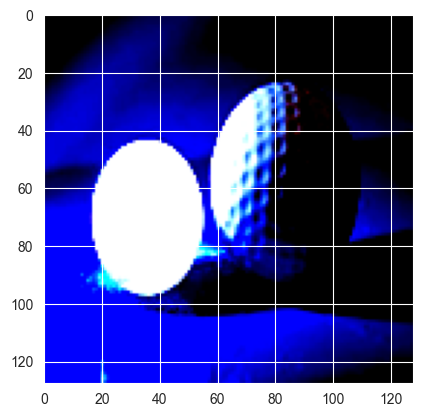

In [25]:
from cnn_training import TestFolderDataset, validate
    
test_transform = val_transform

test_data = TestFolderDataset('test_set',  transform=test_transform)

test_dl = torch.utils.data.DataLoader(test_data,
                                      batch_size= 32,
                                     shuffle = False,
                                     num_workers = 4,
                                     drop_last=False)
plt.imshow(K.tensor_to_image(test_data[0]))

In [26]:
print(validate(model, test_dl, loss_fn, device=device))

Starting validation


  0%|          | 0/4 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

Now implement function `get_predictions`, which takes a model and dataset and outputs a list of class idxs

In [ ]:
from cnn_training import get_predictions
help(get_predictions)

Finally, lets create the submission (predictions on test set). **Make sure you are saving integer values, not floats**.

In [ ]:
def create_submission(preds, fnames):
    with open('submission.csv', 'w') as f:
        f.write('fname, label\n')
        for p, fn in zip(preds,fnames):
            f.write(f"{fn},{p.item()}\n")
    return
# model = model.cuda()
preds = get_predictions(model, test_dl)
create_submission(preds, test_data.fnames)

Your task is to implement the functions above and get as good as possible accuracy on the test set. 
For local evaluation use validation set. If your accuracy is below 70%, you have done something wrong.
Good luck!